In [1]:
import json
import os 
import numpy as np
from pathlib import Path
from datetime import datetime
import pandas as pd
import itertools
import cpi 
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

%matplotlib inline
#sets the fonts to be used by the plots later on
plt.rcParams["font.family"] = "monospace" 
plt.rcParams.update({'font.size': 12})

#change panda dataframe format 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None )


# Data Extraction and Preperation

The data extraction technique performed in part 1 has left us with a directory called $\texttt{raw_film_data}$ full of JSON files which contain the information about each film. The first step that needs to be taken is to find a way of extracting the file names from the folder so that the contained data can be extracted.  

In [2]:
data_directory = "raw_film_data"


def files_from_directory(directory):    
    '''Takes the files from an input directory
       and returns the file names as strings 
       in a list'''       
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            files=[directory+'/'+filename for filename in os.listdir(directory)]
            
            
    return files  

#check first entry 
files_from_directory(data_directory)[0]

'raw_film_data/12_Angry_Men.json'

In [3]:
categories = ['Release Date',
              'Box Office', 
              'Runtime', 
              'Budget',
              'Genres',
              'Production Companies',
              'Language',
              'Production Countries']

Next we need to establish what information we can extract from the files. The following cell contains a series of functions that extract the required data and formats it so that it can be read and written to a pandas dataframe. Given that there is a lot of categorical data, a lot of the functions take a list of information such as genre and formats them into one comma delimited string. For example $\textit{Star Wars}$ is listed on the TMDb API as having 3 genres so the function $\texttt{genre_finder}$ takes the $\textit{Star Wars}$ file and returns a string: $\texttt{Action, Adventure, Science Fiction}$.

The other functions perform similar extraction and formatting where necessary. Some of the JSON data such as $\texttt{Budget}$ and $\texttt{Runtime}$ are already single int or float objects so can be written straight to a dataframe with no manipulation required.

In [4]:
#Use Star Wars as a tester 
with open("raw_film_data/Star_Wars.json") as f:
    example_film = json.load(f)


def title_extractor(data): 
    """Extracts the film title from JSON file"""
    return data['title']

def language_finder(data):
    """Extracts the languages spoken in the film from from JSON file"""
    language_list=[data['spoken_languages'][i]['english_name'] for i in range(len(data['spoken_languages']))]
    return ','.join(language_list)

def original_language(data):
    """Extracts the languages spoken in the film from from JSON file"""
    return data['original_language']   


def production_countries(data):
    """Extracts the production companies from JSON file and creates a list"""
    country_list= [data['production_countries'][i]['name'] for i in range(len(data['production_countries']))]
    return ','.join(country_list)

def genre_finder(data):
    """Extracts the genres from JSON file and creates a list"""
    genre_list = [data['genres'][i]['name'] for i in range(len(data['genres']))]
    return ','.join(genre_list)
    
def date_extractor(data): 
    """Extracts the film title from JSON file"""
    ts = pd.Timestamp(data['release_date'])
    return ts.date()

def production_companies(data): 
    """Extracts the production companies from JSON file"""
    company_list = [data['production_companies'][i]['name'] for i in range(len(data['production_companies']))]
    return ','.join(company_list)


#print some of the function outputs to check if they are working
print(title_extractor(example_film))
print(date_extractor(example_film))
print(genre_finder(example_film))    
print(production_companies(example_film))
print(original_language(example_film))

Star Wars
1977-05-25
Adventure,Action,Science Fiction
Lucasfilm Ltd.,20th Century Fox
en


Looks like the functions are working well. So now we implement these functions to parse the data files and extract the information we need. 

In [5]:
def parse_raw_data(fpath):
    """Reads through a JSON file and extracts the relevent information, creating a pandas dataframe"""
    rows = []
    with open(fpath, "r") as fin:
        jdata = fin.read()
        data = json.loads(jdata)        
        row = {"Film": title_extractor(data)}
        row["Title"] = title_extractor(data)
        row["Release Date"] = date_extractor(data)
        row["Box Office"] = data['revenue']
        row['Runtime'] = data['runtime']        
        row["Budget"] = data['budget']
        row["Genres"] = genre_finder(data) 
        row["Production Companies"] = production_companies(data)  
        row["Language"] = original_language(data)
        row["Production Countries"] = production_countries(data)            
        rows.append(row)
    
    # return back the DataFrame
    return pd.DataFrame(rows)


def parse_files(directory): 
    """Extracts list of file names from a directory and uses each filename to parse data"""
    file_list=files_from_directory(directory)
    total_set = [parse_raw_data(file) for file in file_list]
    total = pd.concat(total_set).set_index("Film")
    return total

#finally run the list of files through parse_files to create the dataset
all_films = parse_files(data_directory)

I want to edit and clean the data a little. Firstly the original language is provided as a code e.g. 'en' is English. I want to fill in the proper names of the most common languages and after a certain point group the languages that are least commonly used into one umbrella category called "Other Languages". This is mainly for identification and grouping at the later stages 

In [6]:
#there isn't really any other way other than hard coding the language keys
language_code = {'en':'English',
                'ja':'Japanese',
                'fr': 'French',       
                'it':'Italian',
                'sv':'Swedish',
                'de':'German',
                'es':'Spanish',
                'ko':'Korean',
                'hi':'Hindi',
                'ru':'Russian',
                'tr':'Other Lang',
                'fa':'Other Lang',
                'et':'Other Lang',
                'ar':'Other Lang',
                'bn':'Other Lang',
                'cn':'Other Lang',
                'da':'Other Lang',
                'pt':'Other Lang'
                    }

all_films["Language"].replace(language_code, inplace=True)

Lets check whether the dataframe has been created with the right format. The aim is to have a dataframe with each row being a film entry and the columns representing the data.

In [7]:
all_films.head()

,Title,Release Date,Box Office,Runtime,Budget,Genres,Production Companies,Language,Production Countries
Film,,,,,,,,,
12 Angry Men,12 Angry Men,1957-04-10,1000000,97,350000,Drama,"United Artists,Orion-Nova Productions",English,United States of America
12 Years a Slave,12 Years a Slave,2013-10-18,187000000,134,20000000,"Drama,History","New Regency Pictures,Plan B Entertainment,River Road Entertainment,Regency Enterprises,Film4 Productions",English,"United States of America,United Kingdom"
1917,1917,2019-12-25,374733942,119,100000000,"War,Drama,Action,Thriller","Universal Pictures,DreamWorks Pictures,Reliance Entertainment,New Republic Pictures,Neal Street Productions,Mogambo Films,Amblin Partners,Entertainment One",English,"Canada,China,India,Spain,United Kingdom,United States of America"
2001: A Space Odyssey,2001: A Space Odyssey,1968-04-02,71923560,149,12000000,"Science Fiction,Mystery,Adventure","Stanley Kubrick Productions,Metro-Goldwyn-Mayer",English,"United Kingdom,United States of America"
3 Idiots,3 Idiots,2009-12-23,70000000,170,9000000,"Drama,Comedy","Vidhu Vinod Chopra Productions,Vinod Chopra Films",Hindi,India


One thing I want to check first is whether there are missing values in the data. This will be most prevelent in the $\texttt{Budget}$ and $\texttt{Box-Office}$ sections which are the main numerical columns. However there may also be missing entries in the categorical sections too. 

In [8]:
for entry in categories:
    print("-> %s" % entry)
    missing_counts = all_films[entry].isnull().sum()
    missing_counts = missing_counts[missing_counts>0]
    if len(missing_counts) == 0:
        print("No missing values found")
    else:
        print(missing_counts)
        
print('----------------------------------')        
        
for entry in ['Budget', 'Box Office', 'Runtime']:
    print("-> %s" % entry)
    zero_counts = all_films[entry].eq(0).sum()    

    if zero_counts == 0:
        print("No zero values found")
    else:
        print("%s zero counts found" % zero_counts)
               

-> Release Date
No missing values found
-> Box Office
No missing values found
-> Runtime
No missing values found
-> Budget
No missing values found
-> Genres
No missing values found
-> Production Companies
No missing values found
-> Language
No missing values found
-> Production Countries
No missing values found
----------------------------------
-> Budget
30 zero counts found
-> Box Office
23 zero counts found
-> Runtime
No zero values found


While there looks to be no $\texttt{Null}$ values in any of the columns, there are a number of missing values in the form of zeros i.e. The budget of a film is listed as 0. This may cause some trouble down the line. For the case of something like runtime it would be easy to simply replace any zero values with the mean or median film runtimes. However for budget and box-office we need to consider the inflation that has occured over the past century. The values for each film are not adjusted for inflation so for example if there is a missing budget value for a film released in 1960, it would be inaccurate to replace the value with the mean of all the budget values because the inflated values from the 21st century drag the average up. 

From a brief persusal of the films it seems that the missing values are mostly attributed to non-american films from pre-2000 where the budget and or box-office is in a different currency. 

Unfortunately this means that any of the 30 Budget and 23 Box office can't be used for any monetary analysis. This is not terrible as there are still $\sim220$ films to examine and the films with the missing values can still be used for qualitative analysis of country/genre/languages etc.

In [9]:
#so we will replace the zero values with NaN values
all_films['Budget'].replace(0, 'NaN',inplace=True)
all_films['Box Office'].replace(0, 'NaN',inplace=True)
all_films.head()

,Title,Release Date,Box Office,Runtime,Budget,Genres,Production Companies,Language,Production Countries
Film,,,,,,,,,
12 Angry Men,12 Angry Men,1957-04-10,1000000,97,350000,Drama,"United Artists,Orion-Nova Productions",English,United States of America
12 Years a Slave,12 Years a Slave,2013-10-18,187000000,134,20000000,"Drama,History","New Regency Pictures,Plan B Entertainment,River Road Entertainment,Regency Enterprises,Film4 Productions",English,"United States of America,United Kingdom"
1917,1917,2019-12-25,374733942,119,100000000,"War,Drama,Action,Thriller","Universal Pictures,DreamWorks Pictures,Reliance Entertainment,New Republic Pictures,Neal Street Productions,Mogambo Films,Amblin Partners,Entertainment One",English,"Canada,China,India,Spain,United Kingdom,United States of America"
2001: A Space Odyssey,2001: A Space Odyssey,1968-04-02,71923560,149,12000000,"Science Fiction,Mystery,Adventure","Stanley Kubrick Productions,Metro-Goldwyn-Mayer",English,"United Kingdom,United States of America"
3 Idiots,3 Idiots,2009-12-23,70000000,170,9000000,"Drama,Comedy","Vidhu Vinod Chopra Productions,Vinod Chopra Films",Hindi,India


# Budget Analysis

I want to first see what sort of relationship exists between the budget of a film and its box office return. Firstly I want to get a dataframe that has the films released in chronological order so that we can see how the money side of the film industry has changed over the past century. 

In [12]:
#create a dataframe that is sorted by release date
#chron films (for chronalogical)
chron_films = all_films.sort_values(by=['Release Date'], ascending=False)
chron_films['year'] = pd.DatetimeIndex(chron_films['Release Date']).year

chron_films.head()

,Title,Release Date,Box Office,Runtime,Budget,Genres,Production Companies,Language,Production Countries,year
Film,,,,,,,,,,
Dune,Dune,2021-09-15,304626162,155,165000000,"Action,Adventure,Science Fiction",Legendary Pictures,English,United States of America,2021
The Father,The Father,2021-02-26,21029340,97,NaN,Drama,"Trademark Films,F Comme Film,Ciné@,Embankment Films,Film4 Productions,Canal+,Ciné+,Orange Studio,Sony Pictures Classics",English,"United Kingdom,France",2021
Hamilton,Hamilton,2020-07-03,NaN,160,NaN,"History,Drama","RadicalMedia,5000 Broadway Productions,Nevis Productions,Old 320 Sycamore",English,United States of America,2020
1917,1917,2019-12-25,374733942,119,100000000,"War,Drama,Action,Thriller","Universal Pictures,DreamWorks Pictures,Reliance Entertainment,New Republic Pictures,Neal Street Productions,Mogambo Films,Amblin Partners,Entertainment One",English,"Canada,China,India,Spain,United Kingdom,United States of America",2019
Ford v Ferrari,Ford v Ferrari,2019-11-13,225508210,153,97600000,"Drama,Action,History","20th Century Fox,TSG Entertainment,Chernin Entertainment,Turnpike Films",English,United States of America,2019


Now that we have a chronological list of the films we can start plotting data. For budgets and revenue in the film industry the numbers one deals with are almost always in the millions (And in recent years, billions). To keep the axis a little bit cleaner, the numbers are all normalised to 1000000. So for example a y- value of 500 is actually $\$500$ million. 

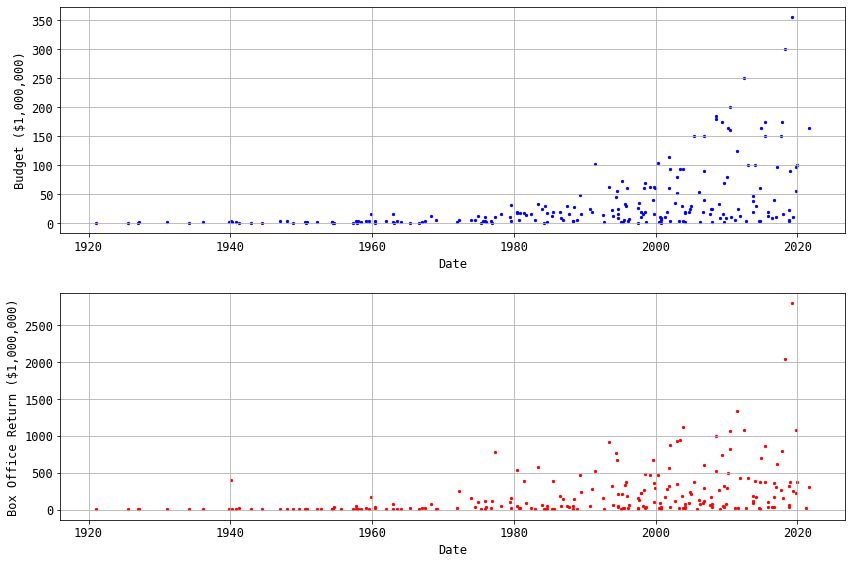

In [11]:
dates=chron_films['Release Date']
budget=[float(chron_films['Budget'][i])/1000000 for i in range(len(chron_films['Budget']))]
revenue=[float(chron_films['Box Office'][i])/1000000 for i in range(len(chron_films['Box Office']))]



#lets plot a basic scatter plot to get an idea of the shape of the data
fig = plt.figure(figsize=(12,8))
ax1, ax2 = fig.subplots(2, 1)
ax1.scatter(dates, budget, c='b', s=5)
ax1.set_xlabel('Date')
ax1.set_ylabel(r'Budget ($1,000,000)')
ax1.grid(True)
ax2.scatter(dates, revenue, c='r',s=5)
ax2.set_xlabel('Date')
ax2.set_ylabel(r'Box Office Return ($1,000,000)')
ax2.grid(True)
fig.tight_layout()

In both cases we see that both budget and box office have increased hugely over time. There is a noticable upward trend beginning the the 1970s

This is most likely a result of two key components. Firstly despite always being a relatively large sector, the film industry grew in the latter half of the 20th century with the advent of the modern blockbuster starting in the late 70s. 

But secondly and probably more importantly, inflation has completely changed the financial scale off of which we are basing our comparison. $\textit{Gone With the Wind}$ was made in 1940 for $\$4$ Million which seems low compared with the $\$100$ million blockbusters of today but when adjusted for inflation we see it is actually closer to around $\$80$ Million. 

Lets see if we can adjust all the films for inflation. We will be using the CPI module which can adjust for US Dollar inflation up to the year 2018 (For some reason the data hasn't been updated so it only works up to 2018. Luckily that's the period that is least affected!).

In [13]:
#first remove any NaN values because cpi.inflate can't handles then like pandas can 
chron_films = chron_films.drop(chron_films[chron_films['Box Office']=='NaN'].index)
chron_films = chron_films.drop(chron_films[chron_films['Budget']=='NaN'].index)

#then replace the values for 2019 and 2020 with 2018. Luckily only a small amount of inflation has occured so there 
#should not be too much of a difference

chron_films["year"].replace({2019: 2018, 2020: 2018, 2021:2018}, inplace=True)

#final check of the remaining data
len(chron_films['Box Office'])

213

In [14]:
#here we apply the cpi.inflate function to the box office and budget numbers
chron_films["Box Office Adj"] = chron_films.apply(lambda x: cpi.inflate(x["Box Office"], x["year"]), axis=1)
chron_films["Budget Adj"] = chron_films.apply(lambda x: cpi.inflate(x["Budget"], x["year"]), axis=1)

#have a quick look and see if the columns have been added
chron_films

,Title,Release Date,Box Office,Runtime,Budget,Genres,Production Companies,Language,Production Countries,year,Box Office Adj,Budget Adj
Film,,,,,,,,,,,,
Dune,Dune,2021-09-15,304626162,155,165000000,"Action,Adventure,Science Fiction",Legendary Pictures,English,United States of America,2018,3.139721e+08,1.700622e+08
1917,1917,2019-12-25,374733942,119,100000000,"War,Drama,Action,Thriller","Universal Pictures,DreamWorks Pictures,Reliance Entertainment,New Republic Pictures,Neal Street Productions,Mogambo Films,Amblin Partners,Entertainment One",English,"Canada,China,India,Spain,United Kingdom,United States of America",2018,3.862308e+08,1.030680e+08
Ford v Ferrari,Ford v Ferrari,2019-11-13,225508210,153,97600000,"Drama,Action,History","20th Century Fox,TSG Entertainment,Chernin Entertainment,Turnpike Films",English,United States of America,2018,2.324268e+08,1.005944e+08
Joker,Joker,2019-10-02,1074251311,122,55000000,"Crime,Thriller,Drama","Warner Bros. Pictures,Joint Effort,Village Roadshow Pictures,Bron Studios,Creative Wealth Media Finance,DC Entertainment,DC Films,DC Comics",English,"Canada,United States of America",2018,1.107210e+09,5.668741e+07
Parasite,Parasite,2019-05-30,257591776,133,11363000,"Comedy,Thriller,Drama","Barunson E&A,CJ Entertainment",Korean,South Korea,2018,2.654947e+08,1.171162e+07
Avengers: Endgame,Avengers: Endgame,2019-04-24,2797800564,181,356000000,"Adventure,Science Fiction,Action",Marvel Studios,English,United States of America,2018,2.883638e+09,3.669221e+08
Spider-Man: Into the Spider-Verse,Spider-Man: Into the Spider-Verse,2018-12-06,375540831,117,90000000,"Action,Adventure,Animation,Science Fiction,Comedy","Sony Pictures,Columbia Pictures,Marvel Entertainment,Avi Arad Productions,Lord Miller Productions,Pascal Pictures,Sony Pictures Animation",English,United States of America,2018,3.870625e+08,9.276121e+07
Green Book,Green Book,2018-11-16,319700000,130,23000000,"Drama,Comedy,Music","Participant,DreamWorks Pictures",English,United States of America,2018,3.295084e+08,2.370564e+07
Capernaum,Capernaum,2018-10-06,64978931,126,4000000,Drama,"Boo Pictures,Mooz Films,Cedrus Invest Bank,Clandestino Filmes,DFI,KNM Films,Les Films des Tournelles,Louverture Films,Open City Films,Sunnyland Film,The Bridge Production",Other Lang,Lebanon,2018,6.697249e+07,4.122721e+06


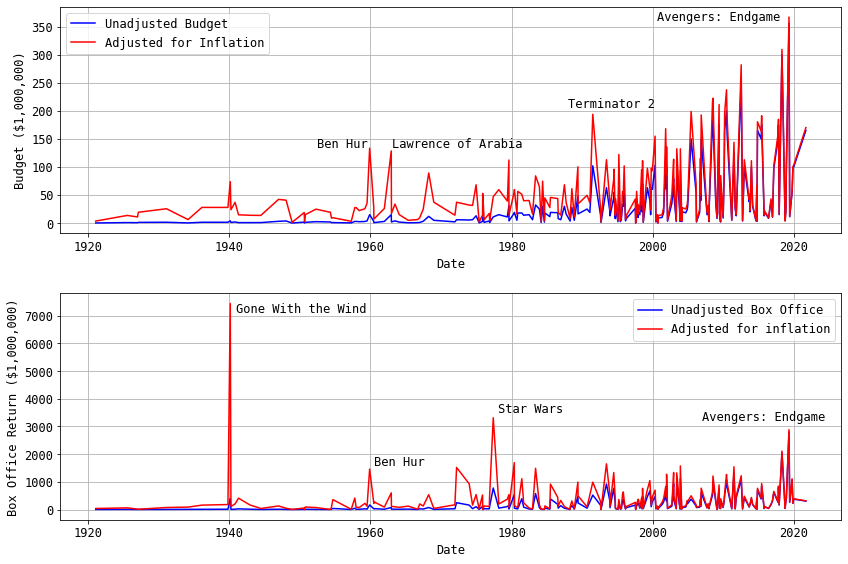

In [15]:
#set variables to be plotted
dates=chron_films['Release Date']

#box office and revenue unadjusted for inflation and normalised to to 1e6
budget=[float(chron_films['Budget'][i])/1000000 for i in range(len(chron_films['Budget']))]
revenue=[float(chron_films['Box Office'][i])/1000000 for i in range(len(chron_films['Box Office']))]

#box office and revenue adjusted for inflation and normalised to to 1e6
adj_budget=[float(chron_films['Budget Adj'][i])/1000000 for i in range(len(chron_films['Budget Adj']))]
adj_revenue=[float(chron_films['Box Office Adj'][i])/1000000 for i in range(len(chron_films['Box Office Adj']))]




fig = plt.figure(figsize=(12,8))
ax1, ax2 = fig.subplots(2, 1)
ax1.plot(dates, budget, 'b-', label='Unadjusted Budget')
ax1.plot(dates, adj_budget,'r-', label = 'Adjusted for Inflation')
ax1.text(datetime(2000,7,20),360,'Avengers: Endgame', rotation=0)
ax1.text(datetime(1963,1,1),135,'Lawrence of Arabia', rotation=0)
ax1.text(datetime(1952,6,1),135,'Ben Hur ', rotation=0)
ax1.text(datetime(1988,1,1),205,'Terminator 2', rotation=0)
ax1.set_xlabel('Date')
ax1.set_ylabel(r'Budget ($1,000,000)')
ax1.grid(True)
ax1.legend(loc='best')


ax2.plot(dates, revenue,'b-', label='Unadjusted Box Office')
ax2.plot(dates, adj_revenue,'r-', label='Adjusted for inflation')
ax2.set_xlabel('Date')
ax2.set_ylabel(r'Box Office Return ($1,000,000)')
ax2.grid(True)
ax2.text(datetime(1960,7,20),1600,'Ben Hur', rotation=0)
ax2.text(datetime(1941,1,1),7100,'Gone With the Wind', rotation=0)
ax2.text(datetime(1978,1,1),3500,'Star Wars', rotation=0)
ax2.text(datetime(2007,1,1),3200,'Avengers: Endgame', rotation=0)
ax2.legend(loc='best')
fig.tight_layout()



We can now gain a more comparitive view of how film budgets and box office have changed over the years. The budgets seeming have increased greatly even with inflation taken into consideration. This may be due to the increase of franchises and studios having more faith in upcoming blockbusters. The \$356000000 budget for Avengers Endgame, the 21st film in the Marvel Cinematic Universe franchise is indicative of this. 

There is a considerable difference with box office however. While $\textit{more}$ films are definitely earning higher revenue at the box office the inflation adjusted data shows that there were films back in the first half of the 20th century that could compete. This is clearly seen in Gone With the Wind's massive box office. More than twice that of Avengers: Endgame which unadjusted for inflation is the 2nd highest grossing film at the box office. 

There are a few key films missing from this list most notably two of the highest grossing films of all time $\textit{Avatar}$ and $\textit{Titanic}$. This is simply down to the list from which the original film data was extracted which is based on user ratings.



Linear Relation (Unadjusted Case): 5.187x +36.103
Linear Relation (Adjusted Case): 5.352x +110.221


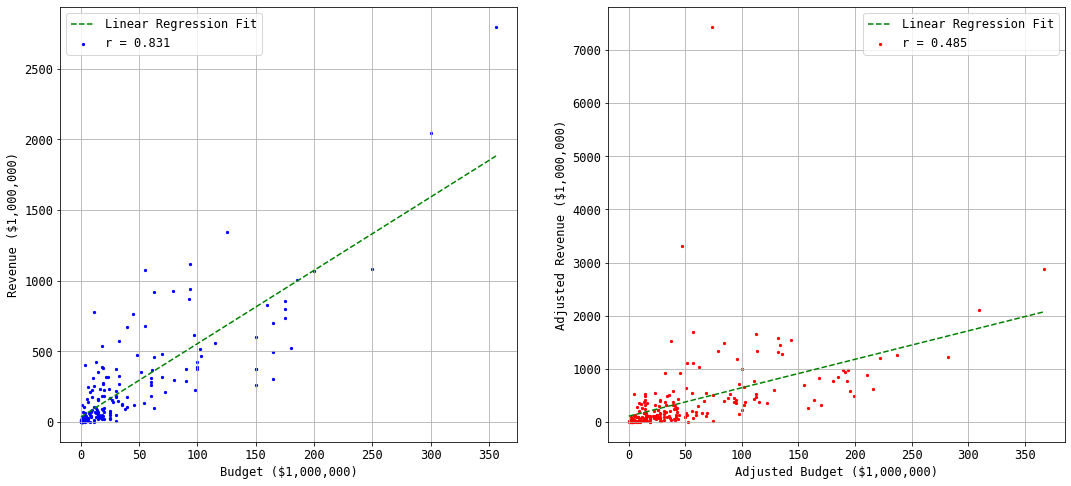

In [16]:
def linear(x, m, c):
    """Linear Function for Curve Fitting"""
    return x*m+c

def find_correlation(x,y): 
    """Determines the correlation coefficient between two variables"""
    r = np.corrcoef(x, y)
    return r[0,1]

def fit_model(func, x,y):
    """Performs a least squares fit using Scipy's curve_fit function"""
    opt, cov = curve_fit(func, x, y)
    return opt, cov


def plot_model(ax,x,y,func=linear):
    """Plots a line of best fit on an ax object"""
    x_values = np.linspace(np.min(x), np.max(x), 1000)
    opt, cov = fit_model(func, x, y)
    return ax.plot(x_values, func(x_values, *opt), 'g--', label = 'Linear Regression Fit')
    

    
    
#check correlation coefficients for both cases
unadj_r=find_correlation(budget, revenue)
adj_r=find_correlation(adj_budget, adj_revenue)

#fit linear functions to data
unadj_opt, unadj_cov = fit_model(linear, budget, revenue)
adj_opt, adj_cov = fit_model(linear, adj_budget, adj_revenue)

    
fig, (ax1, ax2)= plt.subplots(1,2,figsize=(18,8))
ax1.scatter(budget, revenue, c='b', s=5, label="r = %s" % round(unadj_r,3))
ax1.set_xlabel('Budget ($1,000,000)')
ax1.set_ylabel('Revenue ($1,000,000)')
plot_model(ax1, budget, revenue)
ax1.legend(loc='best')
ax1.grid(True)
ax2.scatter(adj_budget, adj_revenue, c='r', s=5, label="r = %s" %round(adj_r,3))
plot_model(ax2, adj_budget, adj_revenue)
ax2.set_xlabel('Adjusted Budget ($1,000,000)')
ax2.set_ylabel('Adjusted Revenue ($1,000,000)')
ax2.grid(True)

ax2.legend(loc='best')

print(r"Linear Relation (Unadjusted Case): %sx +%s" % (round(unadj_opt[0],3),round(unadj_opt[1],3)))
print(r"Linear Relation (Adjusted Case): %sx +%s" % (round(adj_opt[0],3),round(adj_opt[1],3)))

There is a clear positive relation between budget and profit demonstrating that films with higher budgets will earn make more money. Unadjusted for inflation this linear fit is clearly shown. The adjusted budget has a lower correlation coefficient but this is most likely due to the outlying points again. The mammoth box office of $\textit{Gone With the Wind}$ and $\textit{Star Wars}$ drag the trend up and lead to a lower value of r. 

From this it is clear that if studios wish to get make large profits from their films the most probable way to ensure high return seems to be high investment in the film. The linear model seems to suggest that a film will tend to multiply it's budget by a factor of 5. Obviously this is not always the case as films can often bomb financially for external reasons but the r values would suggest there is a correlation. 

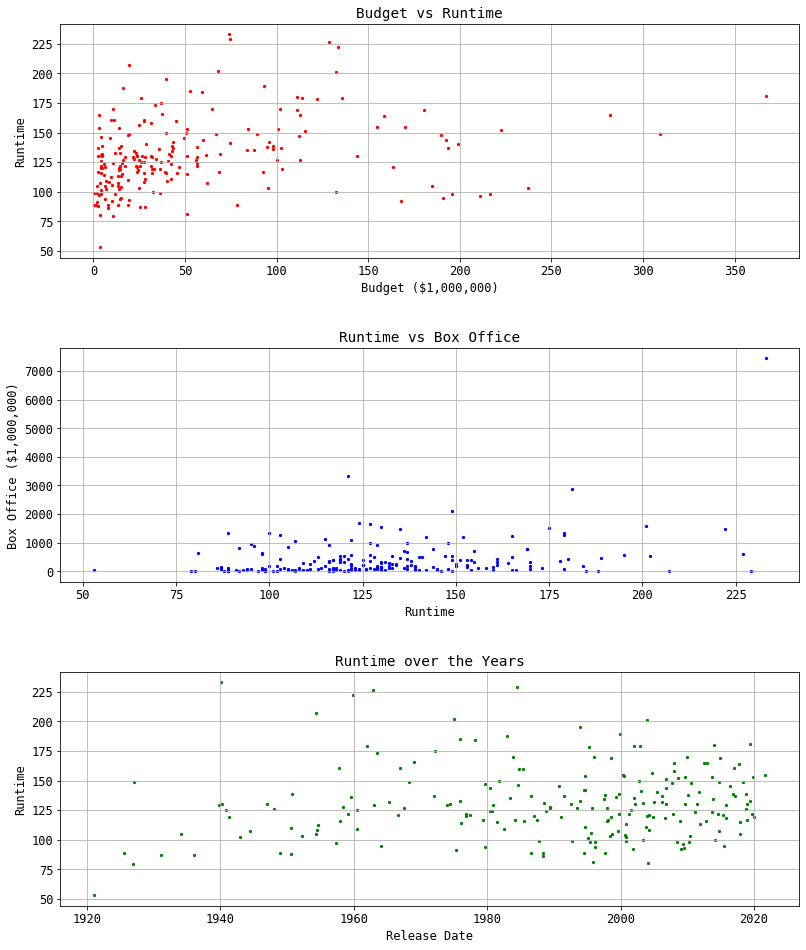

In [17]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(12,14))
ax1.scatter(adj_budget, chron_films['Runtime'], c='r', s=5)
ax1.set_title('Budget vs Runtime')
ax1.set_xlabel('Budget ($1,000,000)')
ax1.set_ylabel('Runtime')
ax1.grid(True)

ax2.scatter(chron_films['Runtime'], adj_revenue, c='b', s=5)
ax2.set_title('Runtime vs Box Office')
ax2.set_xlabel('Runtime')
ax2.set_ylabel('Box Office ($1,000,000)')
ax2.grid(True)

ax3.scatter(dates, chron_films['Runtime'], c='g', s=5)
ax3.set_title('Runtime over the Years')
ax3.set_xlabel('Release Date')
ax3.set_ylabel('Runtime')
ax3.grid(True)

fig.tight_layout(pad=3.0)


Runtime doesn't seem to have any major effect on the box office. A higher budget doesn't guarantee a longer runtime and following on from this a longer runtime doesn't mean a larger box office return. The one exception of this is of course $\textit{Gone with the Wind}$ which has both a huge runtime of 233 minutes and the largest adjusted box office. 

Beginning at the early 20th century films' runtimes seem to start on the lower end of the spectrum with about $\sim80-90$ minutes but by the 1940 have reached the typical lengths of about 2 hours that modern audiences have come to expect. 

# Languages 

Now lets have a look at how budgets and box office vary according to what language the films were originally released in. This really is a study of how film finance varies from country to country but unfortunately TMDb API doesn't included a "Country of Origin" option, only the original language in which the film was released. This will do fine as a general proxy for country. 

In [18]:
#lets have a look at what languages are prominent
all_films.Language.value_counts()

English       178
Japanese       17
Other Lang     10
French          9
Italian         8
Swedish         5
German          5
Spanish         4
Hindi           4
Korean          4
Russian         3
Name: Language, dtype: int64

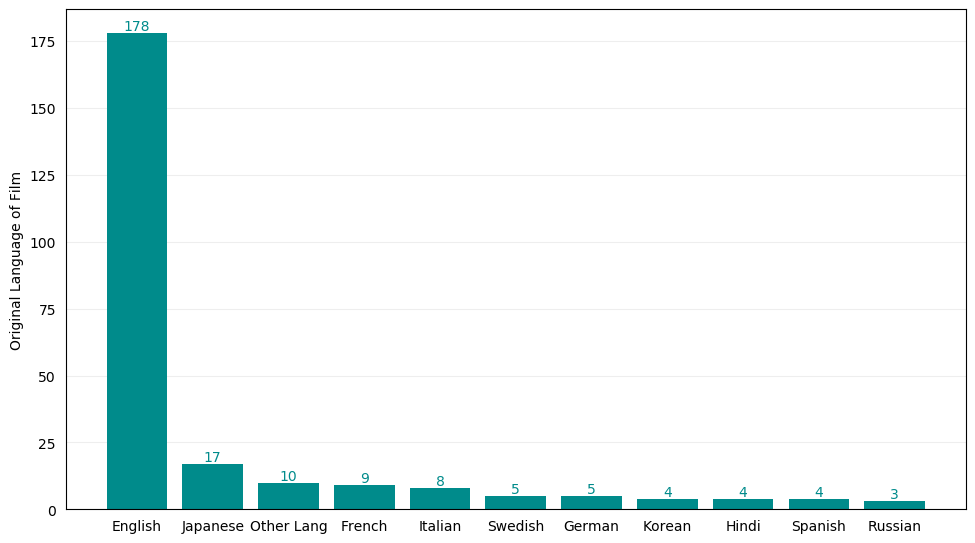

In [19]:
languages = ['English',
'Japanese',
'Other Lang',
'French',
'Italian',
'Swedish',
'German',
'Korean',
'Hindi',
'Spanish',
'Russian']


sizes=[all_films.Language.value_counts()[i] for i in languages]


plt.style.use('default')
fig = plt.figure(figsize=(9,5))
ax = fig.add_axes([0,0,1,1])
bars = ax.bar(languages,sizes, color='darkcyan')
ax.set_ylabel('Original Language of Film')

#remove the ticks from the axis
ax.tick_params(bottom=False, left=False)
#place the grid and the axis behind the data
ax.set_axisbelow(True)
#make the grid a lighter colour grey
ax.grid(axis='y', color='#EEEEEE')


for bar in bars:
    ax.text(
      bar.get_x() + bar.get_width() / 2, #centre the text
      bar.get_height() + 1, #find the bar height
      round(bar.get_height(), 1),
      horizontalalignment='center', color=bars[0].get_facecolor(), weight='normal')
    
plt.show()

Clearly films made in English dominate the list. In terms of what this means, this probably reflects on the data collection resources more than anything. The films were chosen from IMDb which is a website used predominantly by english speakers in America and Europe. 

But also judging by the top films both in our list and annual lists of the highest grossing films the movie industry is dominated by the English speaking market. 

One point I was slightly surprised by is the lack of both Chinese and Indian films in the top data considering that they represent the 2nd and 3rd highest grossing film industries respectively.

In [20]:
#lets take the top languages to examine
languages_of_interest = ['English', 'Japanese', 'French', 'Italian', 'Korean', 'German']

#define a dictionary containing the dataframes of each language
language_data={}

for i in languages:
    language_data[i] = chron_films[chron_films["Language"] == i]


In [21]:
def combine_language_data(column): 
    """Combines the data for one specific language into a dataframe"""
    new_dict={}
    for language in languages:
        new_dict[language] = language_data[language][column]
    combined_language = pd.DataFrame(new_dict)
    return combined_language

language_info = pd.Series({'Runtime': combine_language_data('Runtime'),
                 'Budget': combine_language_data('Budget Adj'),
                 'Box-Off': combine_language_data('Box Office Adj')})



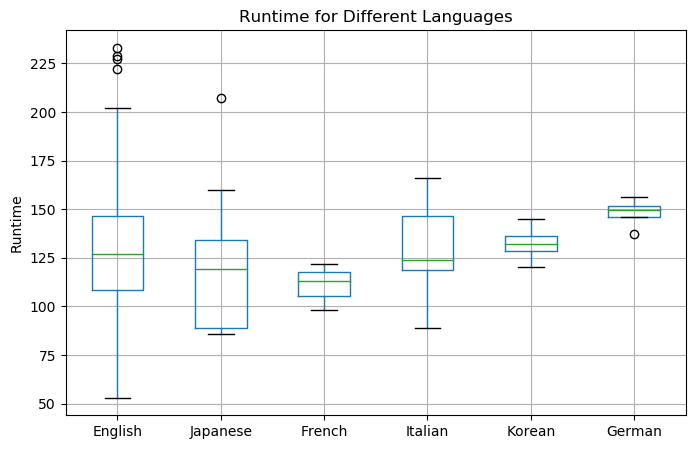

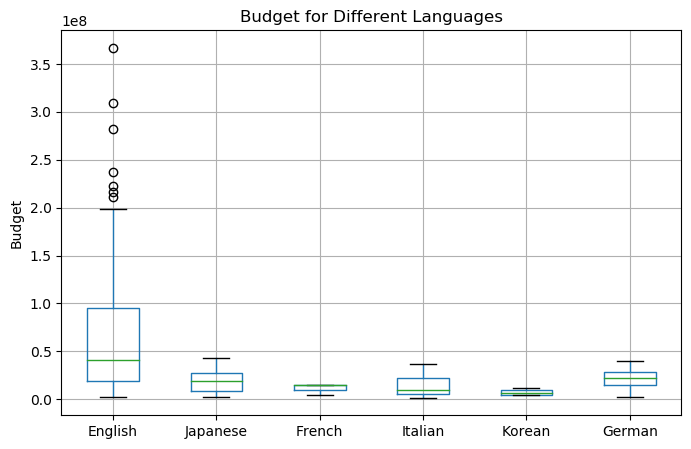

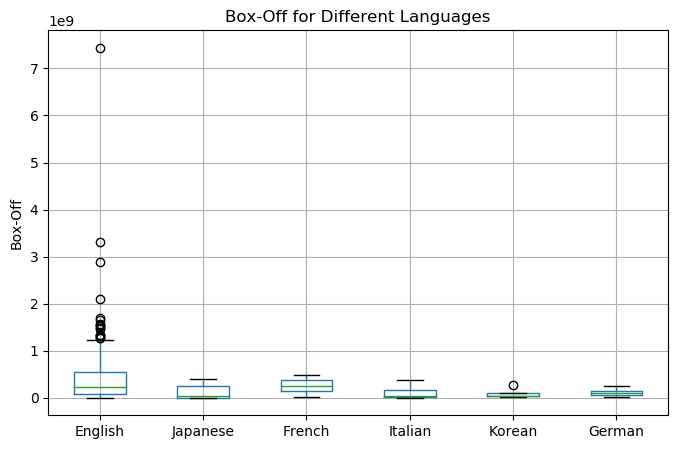

In [22]:
for i in language_info.keys():
    fig, ax = plt.subplots(figsize=(8,5))
    language_info[str(i)].boxplot(column=languages_of_interest)
    ax.set_ylabel(str(i))
    ax.set_title('%s for Different Languages' % i )
    plt.show()

Interestly enough the runtimes of the films seem to all be similar enough. They all have a similar median value. English film has more outliers with a number of films approaching 200 minutes. Outside of English films, Germany displays the longest average runtimes with a higher median than the other languages and Italy shows the greatest range between maxmium and minimum film length. 

The monetary box plots are a little more unclear. This is primarily down the the large number of high budget and high box office outliers in the English language category which has a maximum of $\$200$ million, well above the other languages that have maximum budgets around $\$50$ million. From the budget plot it looks as if German films have a slightly higher budget than the other non-English films.  

The box office plot is completely condensed due to the one massive outlier with the biggest budget (which is of course, Gone with the Wind). It is difficult to fully gain much understanding from this plot due to how scrunched up the boxes are but from a cursory glance it seems as though French is the most profitable cinema out of the non-English categories.

In [23]:
def basic_info(language, info):
    """Extract basic column info into a dataframe"""
    rows=[]
    row = {"Language": language}
    row["Min"] = language_info[info][language].min()
    row["Max"] = language_info[info][language].max()
    row["Mean"] = language_info[info][language].mean()
    row["Median"] = language_info[info][language].median()
    rows.append(row)
    return pd.DataFrame(rows).set_index("Language")

def concat_dataframe(info):
    """Merges a collection of dataframes into one"""
    dataframes = [basic_info(i, info) for i in languages_of_interest]
    total = pd.concat(dataframes)
    total.style.set_caption(info)
    return total


#intitialise our dataframes
runtime_lang = concat_dataframe('Runtime')
boxoff_lang = concat_dataframe('Box-Off')
budget_lang = concat_dataframe('Budget')

#display the runtime data as an example
runtime_lang

,Min,Max,Mean,Median
Language,,,,
English,53.0,233.0,130.707602,127.0
Japanese,86.0,207.0,125.000000,119.0
French,98.0,122.0,111.000000,113.0
Italian,89.0,166.0,129.857143,124.0
Korean,120.0,145.0,132.250000,132.0
German,137.0,156.0,148.000000,149.5


Because the box plots for the languages were a little unclear we are going to examine some bar charts of data instead which should hopefully show some unimpeded results.

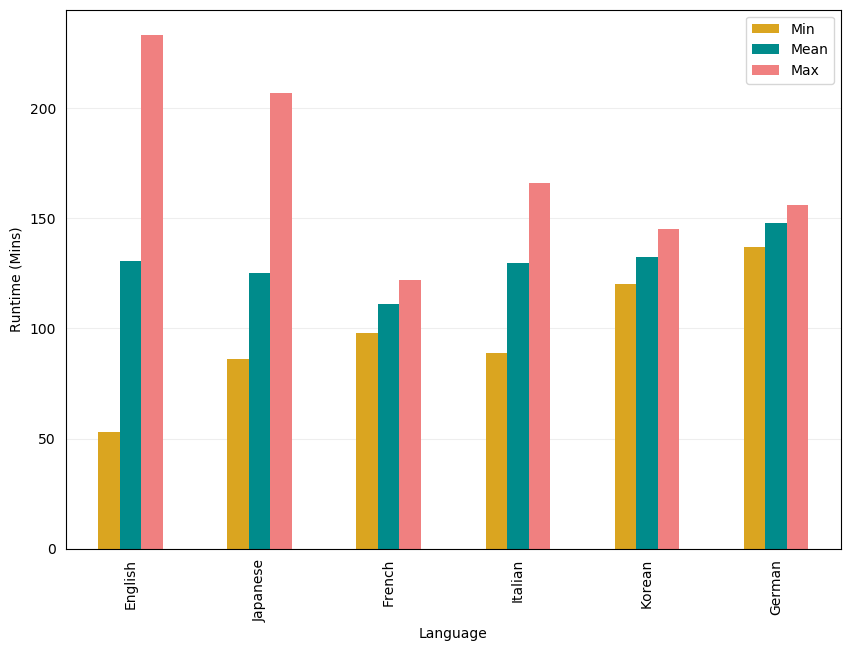

In [24]:
#define some nice colours
color_list = ['goldenrod', 'darkcyan', 'lightcoral']


fig, ax = plt.subplots(1, figsize=(10,7))

bar = runtime_lang.plot.bar(ax=ax,y=['Min', 'Mean' ,'Max'], color=color_list)
ax.set_ylabel('Runtime (Mins)')
ax.grid(axis='y')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.grid(axis='y', color='#EEEEEE')

The minimum, maximum and mean runtimes for each countries films are shown in the above bar chart. Similar to the trend seen from the box plot the run times are all generally the same coming in with a mean value around $\sim130$ minutes. French language films show the shortest average runtimes at 111 minutes. English actually shows the largest $\textit{and}$ shortest films. The shortest is attributed to Charlie Chaplin's The Kid which clocks in at 55 minutes. Japan also shows a surprisingly high runtime.

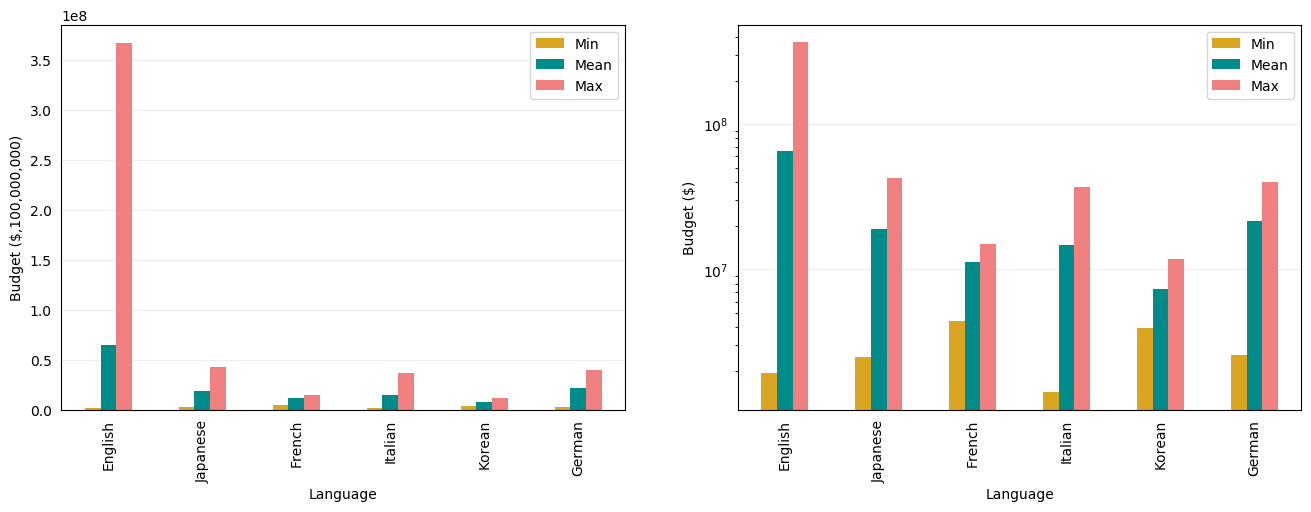

In [25]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,5))

bar1 = budget_lang.plot.bar(ax=ax1,y=['Min', 'Mean' ,'Max'], color=color_list)
bar2 = budget_lang.plot.bar(ax=ax2,y=['Min', 'Mean' ,'Max'], color=color_list)

ax1.set_ylabel('Budget ($,100,000,000)')
ax1.grid(axis='y')
ax1.tick_params(bottom=False, left=False)
ax1.set_axisbelow(True)
ax1.grid(axis='y', color='#EEEEEE')

ax2.set_ylabel('Budget ($)')
ax2.set_yscale('log')
ax2.grid(axis='y')
#ax.set_xlim(0,35)
ax2.tick_params(bottom=False, left=False)
ax2.set_axisbelow(True)
ax2.grid(axis='y', color='#EEEEEE')



Next up we are examining the budgets of the films. The large maxmium budget we see in the English category is the 2019 film Avengers: Endgame which had a production budget of $\$350$ million. Because this vastly overshadows the budgets in the other categorys all of which are on a relatively similar scale I have included a log plot of the data which scales down the high English values and allows more more intricate examination of the other languages. 

Here we see that French and Korean films are allocated the lowest budgets (seen with both the mean and the max values) while Japanese and German films get the most money (not $\$350$ million but more than the other international films). 

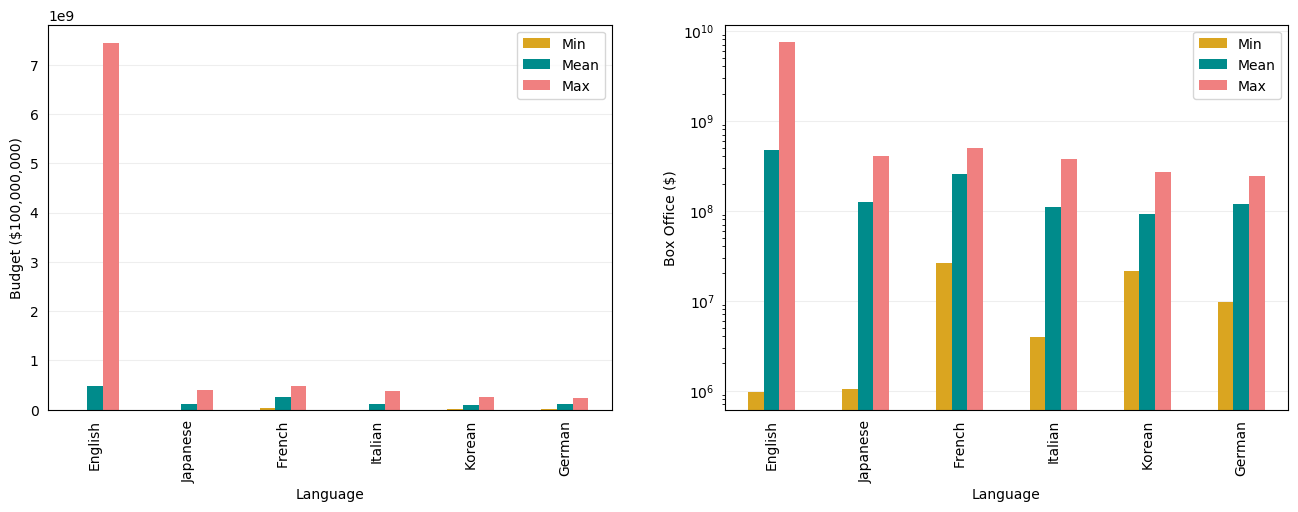

In [26]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,5))

bar1 = boxoff_lang.plot.bar(ax=ax1,y=['Min', 'Mean' ,'Max'], color=color_list)
bar2 = boxoff_lang.plot.bar(ax=ax2,y=['Min', 'Mean' ,'Max'], color=color_list)

ax1.set_ylabel('Budget ($100,000,000)')
ax1.grid(axis='y')
ax1.tick_params(bottom=False, left=False)
ax1.set_axisbelow(True)
ax1.grid(axis='y', color='#EEEEEE')

ax2.set_ylabel('Box Office ($)')
ax2.set_yscale('log')
ax2.grid(axis='y')
#ax.set_xlim(0,35)
ax2.tick_params(bottom=False, left=False)
ax2.set_axisbelow(True)
ax2.grid(axis='y', color='#EEEEEE')

Again, thanks to the continued input of Gone with the Wind's gargantuan box-office, it was found to be more fruitful to plot the data on a log plot. Interestingly, French films seen to rake in the most money behind English across the minimum, mean, and max values. The least profitable films are German which is odd considering they have a relatively high budget when compared to the other European and Asian languages. 

# Genre Analysis

The first thing I want to examine is the breakdown of genres across the films. 


To do this we will cycle through the genre column for the films. Currently the genre coloum contains a string of all the genres the film is listed under. We will split them into a list of genres using Pythons $\texttt{.split()}$ function.

In [27]:
total_genres=[]

for genres in all_films.Genres:
    genre_list=genres.split(',')
    for i in genre_list:
        total_genres.append(i)

genres_df=pd.Series(total_genres)

total=genres_df.value_counts()

print(total)

genres = ['Drama',
'Thriller',
'Crime',
'Action',
'Comedy',
'Adventure',
'War',
'History',
'Mystery',
'Other']

Drama              179
Thriller            54
Crime               51
Action              47
Comedy              43
Adventure           40
War                 31
History             26
Mystery             26
Science Fiction     25
Romance             22
Animation           22
Fantasy             19
Family              18
Music                6
Western              6
Horror               5
dtype: int64


In [28]:
#I made this cell before I realised I could just use df.values_count()
#but I had already written it and it works so I left it in even if it 
#is not the most elegant way of doing it 

comedy = []
action = []
adventure = []
drama = []
mystery = []
history = []
thriller = []
war = []
crime=[]
other = []


total_number=0
total_named=0
for genre in all_films.Genres:
    genre_list=genre.split(',')
    for i in genre_list:
        total_number+=1
        if i == "Comedy":
            total_named+=1
            comedy.append(i)
        elif i == "Drama":
            total_named+=1
            drama.append(i)
        elif i == "Action":
            total_named+=1
            action.append(i)
        elif i == "Crime":
            total_named+=1
            crime.append(i)
        elif i == "Adventure":
            total_named+=1
            adventure.append(i)
        elif i == "Mystery":
            total_named+=1
            mystery.append(i)
        elif i == "Thriller":
            total_named+=1
            thriller.append(i)
        elif i == "War":
            total_named+=1
            war.append(i)
        elif i == "History":
            total_named+=1
            history.append(i)
        else:
            other.append(i)            

In [29]:
def genre_extractor(genre):
    """Extracts subset of dataframe based on genre"""
    return chron_films[chron_films['Genres'].str.contains(genre)]

genre_data={}    
for i in genres:
    genre_data[i] = genre_extractor(i)

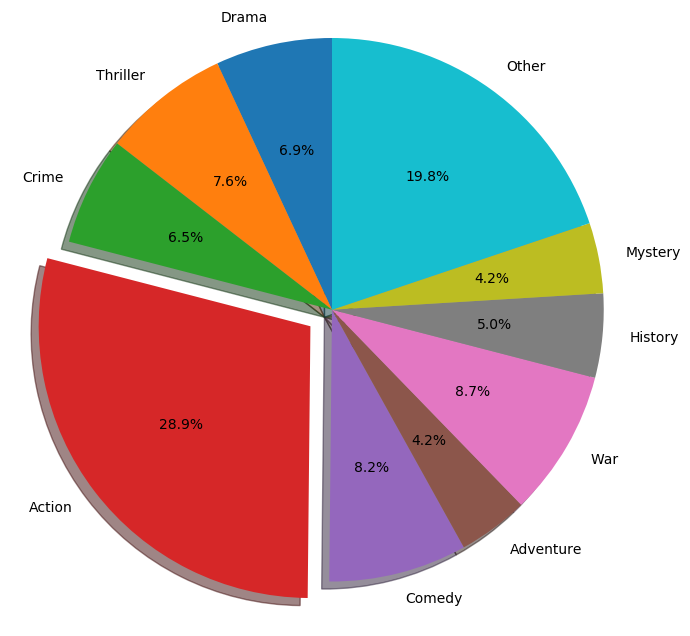

In [30]:
sizes = [len(comedy)/total_number, 
         len(action)/total_number,
         len(adventure)/total_number,
         len(drama)/total_number,
         len(crime)/total_number,
         len(mystery)/total_number,
         len(thriller)/total_number,
         len(war)/total_number,
         len(history)/total_number,
         len(other)/total_number]

#make 'Drama' pop out as it is the largest section
explode = (0, 0, 0, 0.1, 0, 0, 0, 0, 0,0)
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, explode=explode, labels=genres, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 

plt.show()

Clearly drama is the largest genre accounting for 28.9% of the total film genres. The fact that drama is the largest category is not totally unexpected. Any film that is considered serious or "prestige" is often listed as being in the the dramatic genre along with whatever other genre it fills. For example according to the data we have extracted from TMB the 2001 film $\textit{Gladiator}$ falls under Action, Adventure but also Drama. This is most likely why it is so highly placed among the genres as it is included as a sort of sub-genre for many films even if it is not their primary genre. 

This is somewhat proven by how equal most of the other genres are. All the other genres (except for Other which I will explain shortly) are on the same order of $\sim 4-8\%$. This would suggest that the top rated films are a good blend of genres with no real outliers.

The $\textbf{Other}$ category is made up of 

-Horror

-Science Fiction

-Musical 

-Western

-Romance

-Family 

-Animation

These groups are rare thoughout the film but combined make up a fair portion of the total set. The most common of these additional genres is Science Fiction which makes up $4\%$ of the addition unlisted genres while Horror is the least popular making up only $0.8\%$

In [31]:
#create a function that combines a given column for all 
def combine_genre_data(column): 
    new_dict={}
    for genre in genres:
        new_dict[genre] = genre_data[genre][column]
    combined_genre = pd.DataFrame(new_dict)
    return combined_genre


genre_info = pd.Series({'Runtime': combine_genre_data('Runtime'),
                 'Budget': combine_genre_data('Budget Adj'),
                 'Box-Off': combine_genre_data('Box Office Adj')})


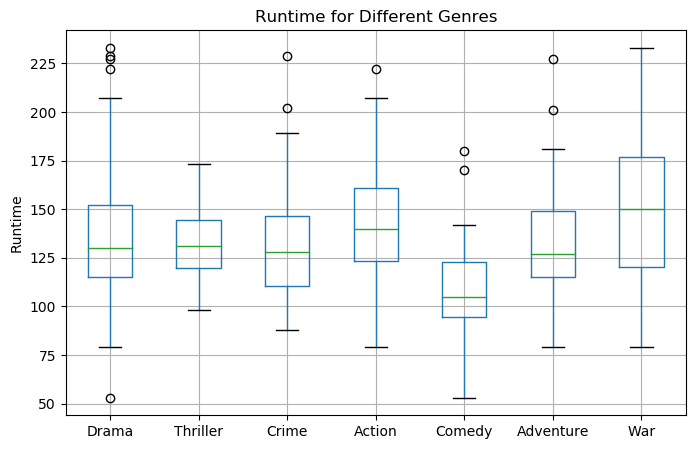

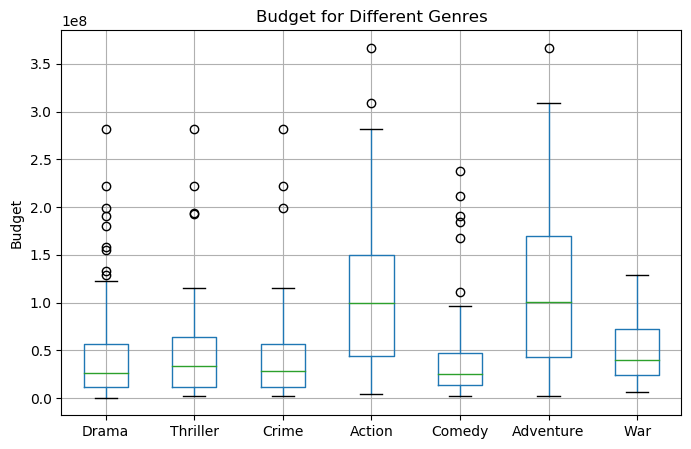

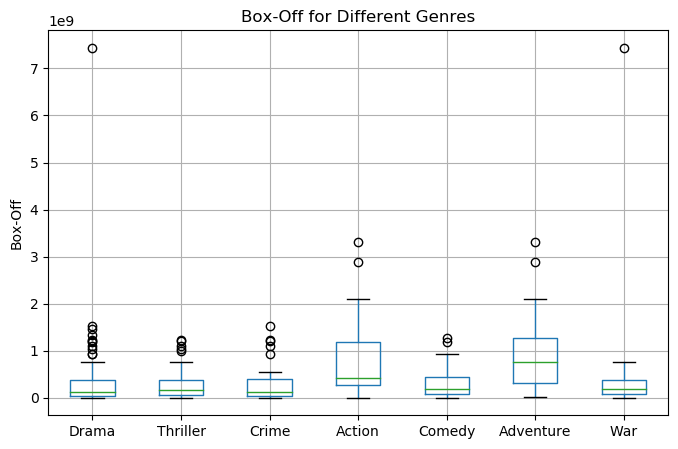

In [32]:
for i in genre_info.keys():
    fig, ax = plt.subplots(figsize=(8,5))
    genre_info[str(i)].boxplot(column=genres[0:7])
    ax.set_ylabel(str(i))
    ax.set_title('%s for Different Genres' % i )
    plt.show()

The above boxplots highlight the trends in Runtime, Box Office, and Budget for each genre. 

The top plot investigates the runtime. War and Action movies have the highest runtimes both from their maximums and their median values. They have median runtimes approaching 2 and a half hours which means they have the potenital to be much longer as demonstrated by their whiskers. Comedy is noticablely shorter on the whole than the other genres with a median runtime of about 105 minutes. 

The action and adventure genres are given the highest budgets according to the second plot. Again comedy has the lowest average budget value alongside crime. One point of note here is that the overlap in genres is beginning to become apparent. This is indicated by the Drama, Thriller, and Crime genres having identical outliers in the highest values. As previously mentioned this is to be expected as many films over a range of genres are also condsiders dramas. 

Finally the last plot shows adjusted box office. Like budget, Action and Adventure are the big hitters here with an average box office of $\sim\$500 - \$700$ million. War and Crime also seem to have the lowest revenue out of the list. Much like the language box plots this final plot is slightly squished due to the large outliers so we will examine a bar chart of the data. 

In [33]:
def basic_genre_info(genre, info):
    rows=[]
    row = {"Genre": genre}
    row["Min"] = genre_info[info][genre].min()
    row["Max"] = genre_info[info][genre].max()
    row["Mean"] = genre_info[info][genre].mean()
    row["Median"] = genre_info[info][genre].median()
    rows.append(row)
    return pd.DataFrame(rows).set_index("Genre")

def concat_genre_dataframe(info):
    dataframes = [basic_genre_info(i, info) for i in genres[0:7]]
    total = pd.concat(dataframes)
    total.style.set_caption(info)
    return total



runtime_genre = concat_genre_dataframe('Runtime')
boxoff_genre = concat_genre_dataframe('Box-Off')
budget_genre = concat_genre_dataframe('Budget')

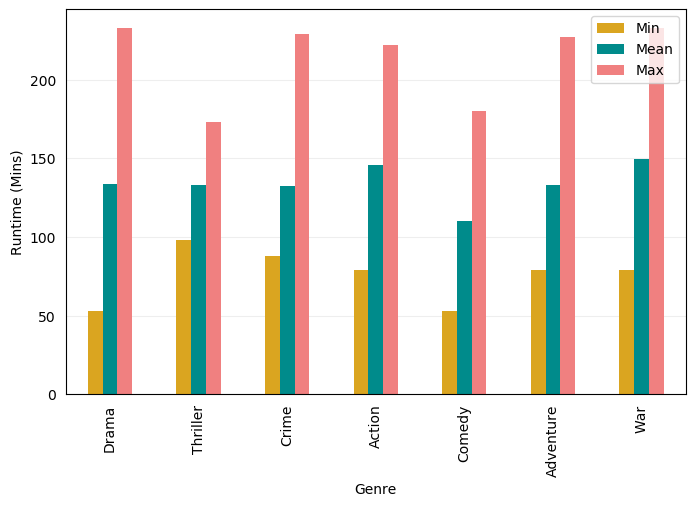

In [34]:
fig, ax = plt.subplots(1, figsize=(8,5))

bar = runtime_genre.plot.bar(ax=ax,y=['Min', 'Mean' ,'Max'], color=color_list)
ax.set_ylabel('Runtime (Mins)')
ax.grid(axis='y')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.grid(axis='y', color='#EEEEEE')

The bar chart for the runtime essentially proves what the boxplot told us earlier. The average runtime over the genres is fairly similar but with war and action films displaying fractionally longer runtimes and comedy fractionally shorter. Comedy also shows the lowest minimum alongside drama. The maximum values are all akin to one another except the noticable dip with Thrillers and Comedies.  

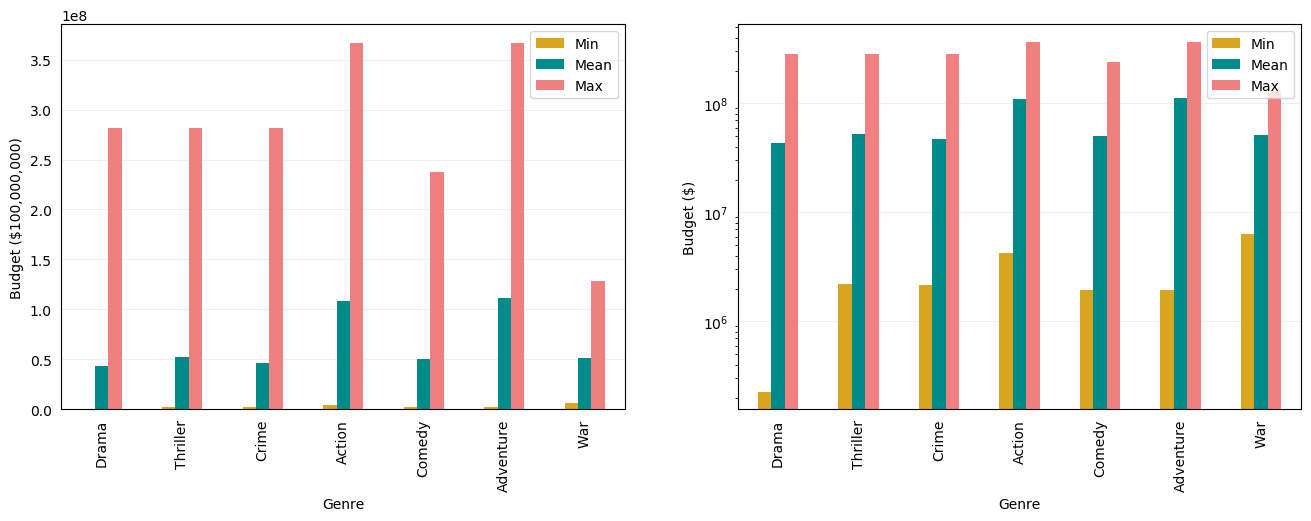

In [35]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,5))

bar1 = budget_genre.plot.bar(ax=ax1,y=['Min', 'Mean' ,'Max'], color=color_list)
bar2 = budget_genre.plot.bar(ax=ax2,y=['Min', 'Mean' ,'Max'], color=color_list)

ax1.set_ylabel('Budget ($100,000,000)')
ax1.grid(axis='y')
ax1.tick_params(bottom=False, left=False)
ax1.set_axisbelow(True)
ax1.grid(axis='y', color='#EEEEEE')


ax2.set_ylabel('Budget ($)')
ax2.set_yscale('log')
ax2.grid(axis='y')
#ax.set_xlim(0,35)
ax2.tick_params(bottom=False, left=False)
ax2.set_axisbelow(True)
ax2.grid(axis='y', color='#EEEEEE')

Action and adventure have the highest average budget (They also have higher maxmima). We see a distict minimum with the budget for drama which as seen in the log plot is almost an order of magnitude less than the order minima. Its mean budget is comparible with the other genres. 

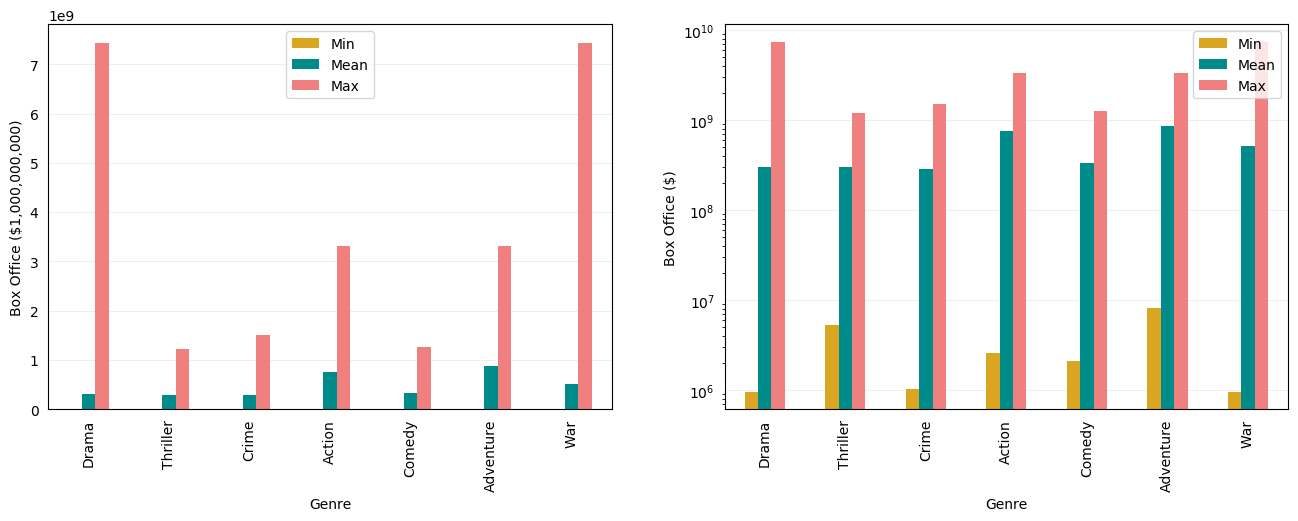

In [36]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,5))

bar1 = boxoff_genre.plot.bar(ax=ax1,y=['Min', 'Mean' ,'Max'], color=color_list)
bar2 = boxoff_genre.plot.bar(ax=ax2,y=['Min', 'Mean' ,'Max'], color=color_list)

ax1.set_ylabel('Box Office ($1,000,000,000)')
ax1.grid(axis='y')
ax1.tick_params(bottom=False, left=False)
ax1.set_axisbelow(True)
ax1.grid(axis='y', color='#EEEEEE')


ax2.set_ylabel('Box Office ($)')
ax2.set_yscale('log')
ax2.grid(axis='y')
ax2.tick_params(bottom=False, left=False)
ax2.set_axisbelow(True)
ax2.grid(axis='y', color='#EEEEEE')

The log plot of genre vs Box Office shows that drama and war the the largest maxmium by far (No guesses for which genres Gone with the Wind falls under) however examining the mean revenues we see that action, adventure and war are the most profitable genres. This makes sense considering the popularity of superhero films and action blockbusters in recent years while throughout the history of cinema war films have remained popular. 

Crime and Mystery are the two least popular genres based on the mean values obtained from the data. This could maybe be because crime films can often be quite violent (films such as Goodfellas and the Godfather) which cuts out a large amount of potential audience revenue from families and younger audiences. 

I next want to see what sort of overlap exists between each genre. For example how many action films are also comedies or how many war films can also be classed as dramas. Hopefully this may further explain the large number of dramas that are present in the genre list.

In [37]:
#We will work with the 7 most popular genres according to the data 
genre_overlap_raw = {}
for i in genres[0:7]: 
    genre_overlap_raw[i]=[]


for j in genres[0:7]:
    for genre in all_films.Genres:
        genre_list=genre.split(',')
        if j in genre_list:
            genre_overlap_raw[j].append(genre_list[0:])
            

def chain_genres(genre_title):
    """Takes the lists of genres from each film and chains them 
        together into one big list"""
    x = genre_overlap_raw[genre_title]
    list_x = list(itertools.chain.from_iterable(x))
    clean_list = []
    for i in range(len(list_x)): 
        if list_x[i] != genre_title: 
            clean_list.append(list_x[i])
    return clean_list


genre_overlap_clean= {}
for i in genres[0:7]:
    genre_overlap_clean[i] = chain_genres(i)


In [38]:
def overlap_counter(base_genre): 
    """Counts the overlapping genres for each single genres"""
    return [genre_overlap_clean[base_genre].count(i) for i in genres[0:7]]


count_genres = {}
for i in genres[0:7]:
    count_genres[i] = overlap_counter(i)

    
#compile a dataframe with genres as rows AND columns with the overlapping counts as data    
genres_comparison = pd.DataFrame(count_genres, columns = genres[0:7]).set_index(pd.Index(list(count_genres.keys())))


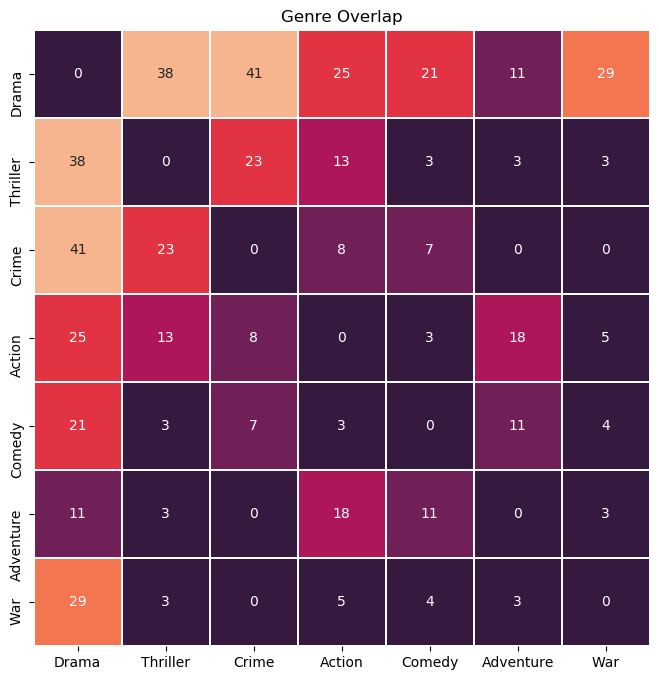

In [39]:
def plot_heatmap(title, df_in, figsize=(8, 8)):
    """Takes a dataframe and plots a heatmap"""
    cmap = sns.color_palette("rocket")    
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df_in, square=True, cbar=False,
                annot=True, cmap=cmap, linewidths=0.5, vmin=-1)
    ax.set_title(title)
    
plot_heatmap('Genre Overlap', genres_comparison)    

From this colourmap we see the films that share genres the most.

The biggest overlap is between Crime and Drama followed by Thriller and Drama, and Drama and War. The fact that drama overlaps so prominently with the other genres is not particularly surprising considering it is the most prevelent genre seen earlier in the pie chart. This clearly seen from the high numbers in the first row/column. This once again may come down to the fact drama is often considered a general umbrella term for any film with a serious subject matter. 



Adventure and Comedy are the genres that overlap least in the chart. We see some expected behavior with Adventure and Action appearing together for 18 films. Almost paradoxically the largest overlap with Comedy is with Drama.

# Production Companies and Countries


Finally we will have a look at the production companies involved in the making of the films. Does more production companies imply higher budgets? Do films that are produced in a variety of locations require more companies to manage production? 

In [40]:
#establish the
company_number = []
company_names = []
total_company_names = []

for i in chron_films['Production Companies']: 
    company_list = i.split(',')
    company_names.append(company_list)
    company_number.append(len(company_list))
    for j in company_list: 
        total_company_names.append(j)

chron_films['Number of Companies'] = company_number 

#lets see the top 10 most common companies
total_company_names = pd.Series(total_company_names)
total_company_names.value_counts()[0:10]

Warner Bros. Pictures    29
United Artists           18
Paramount                16
Columbia Pictures        15
Universal Pictures       14
20th Century Fox         11
Pixar                     8
Walt Disney Pictures      7
Metro-Goldwyn-Mayer       7
Miramax                   7
dtype: int64

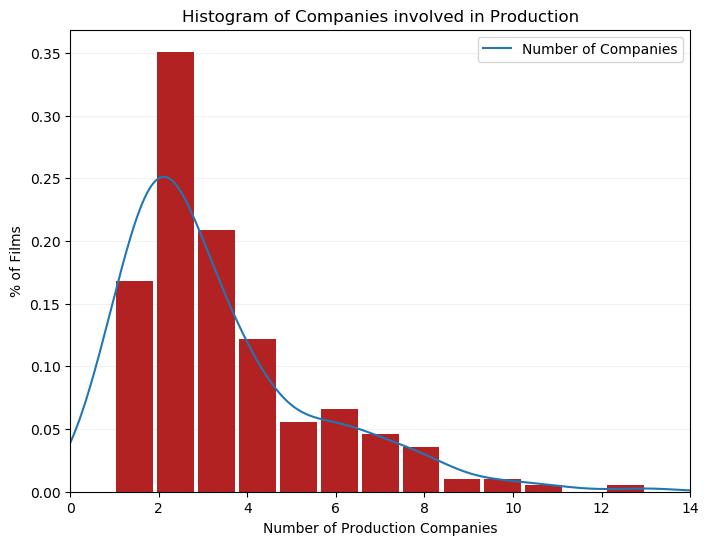

In [41]:
fig, ax = plt.subplots(1, figsize = (8,6))

chron_films['Number of Companies'].plot.hist(ax=ax, grid=True, bins=13, rwidth=0.9,
                   color='firebrick',density=True)
chron_films['Number of Companies'].plot.kde(ax=ax, legend=True)
ax.set_title('Histogram of Companies involved in Production')
ax.set_xlabel('Number of Production Companies')
ax.set_ylabel('% of Films')
ax.set_xlim(0,chron_films['Number of Companies'].max()+1)
ax.grid(axis='y', alpha=0.75)
ax.set_axisbelow(True)
ax.grid(axis='y', color='#EEEEEE')

The histogram and additional density plot shows that most films have between 1 and 4 production companies producing their films. This matches expected trends with most popular films which sees big multi million dollar companies such as 'Universal' or 'MGM' taking the reigns for blockbuster films in order to maximise profits to their companies by not having to split the earnings. 

The film with the most companies involved is the 2002 film 'The Pianist' with 13 companies producing the film; a mix of German and Polish companies. 

Text(0, 0.5, 'Budget ($1,000,000)')

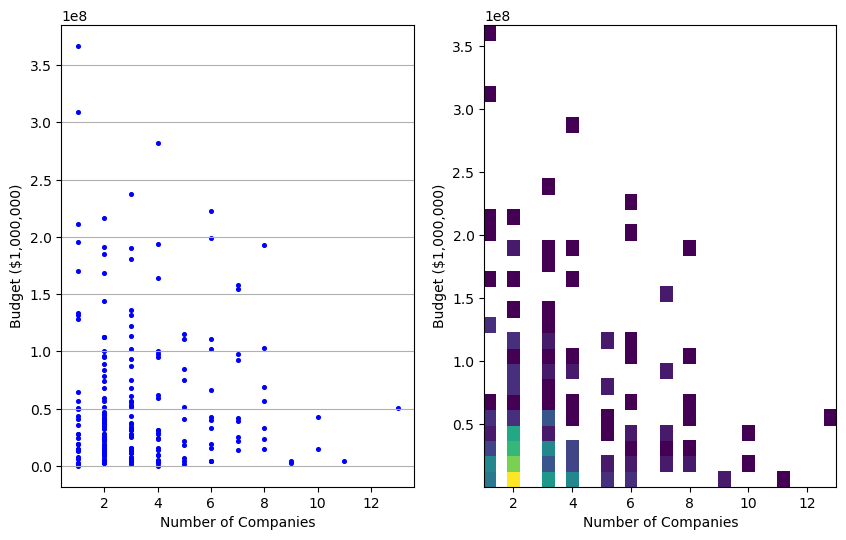

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,6))

ax1.scatter(chron_films['Number of Companies'], chron_films['Budget Adj'], c='b', s=7)
ax1.set_xlabel('Number of Companies')
ax1.set_ylabel(r'Budget ($1,000,000)')
ax1.grid(axis='y')


ax2.hist2d(chron_films['Number of Companies'],chron_films['Budget Adj'], bins = 30, cmin=1)
ax2.set_xlabel('Number of Companies')
ax2.set_ylabel(r'Budget ($1,000,000)')

The above scatter plot was an attempt to discern a possible relation between number of production companies and the budget that a film receives with the question being: does more companies equal more money towards a film. The fact that the x-axis has very few values and all are integer values means the data is a little jagged and unclear. There in fact seems to be a $\textit{downward}$ trend with higher budgets being provided by less companies but this plot is somewhat misleading as the density of points at a certain location on the plot is hidden. 

Therefore I have included a 2D histogram which shows that in actuality the majority of films have relatively small budgets provided by 2 companies

In [43]:
numbers = [x for x in range(chron_films['Number of Companies'].max()+1)]


def number_extractor(num):
    """Extracts subset of dataframe based on genre"""
    return chron_films[chron_films['Number of Companies']==num]

number_data={}    
for i in numbers:
    number_data[str(i)] = number_extractor(i)
    

In [44]:
#similar to language and genre we define a data set with amound of companies as the index
def combine_number_data(column): 
    new_dict={}
    for number in numbers:
        new_dict[str(number)] = number_data[str(number)][column]
    combined_number = pd.DataFrame(new_dict)
    return combined_number


number_info = pd.Series({'Runtime': combine_number_data('Runtime'),
                 'Budget': combine_number_data('Budget Adj'),
                 'Box-Off': combine_number_data('Box Office Adj')})

In [45]:
def basic_num_info(numbers, info):
    rows=[]
    row = {"Number of Co.": str(numbers)}
    row["Min"] = number_info[info][str(numbers)].min()
    row["Max"] = number_info[info][str(numbers)].max()
    row["Mean"] = number_info[info][str(numbers)].mean()
    row["Median"] = number_info[info][str(numbers)].median()
    rows.append(row)
    return pd.DataFrame(rows).set_index("Number of Co.")

def concat_num_dataframe(info):
    dataframes = [basic_num_info(i, info) for i in numbers]
    total = pd.concat(dataframes)
    total.style.set_caption(info)
    return total


#only really interested in budget for this one (and maybe box office)
boxoff_num = concat_num_dataframe('Box-Off')
budget_num = concat_num_dataframe('Budget')

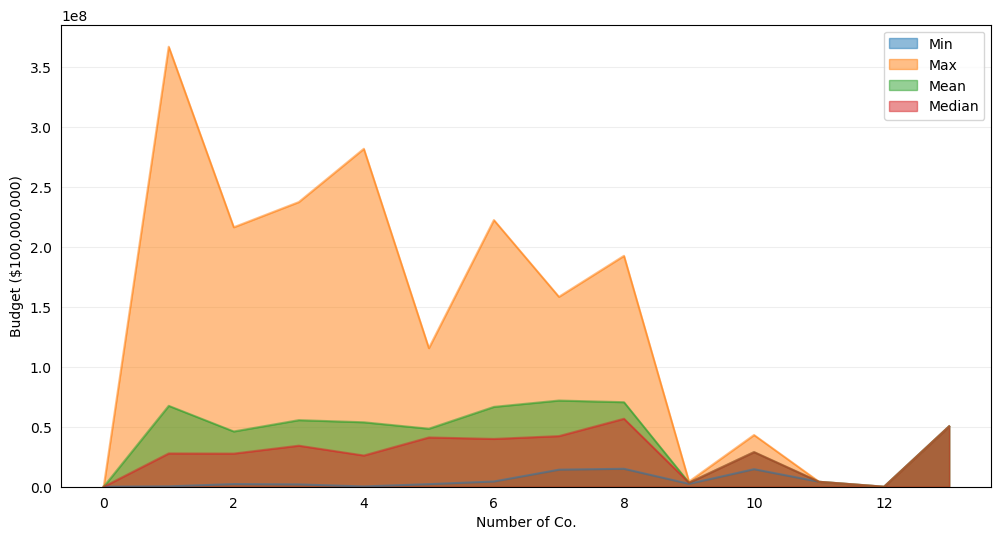

In [46]:
fig, ax1 = plt.subplots(1, figsize=(12,6))
budget_num.plot.area(ax=ax1, stacked=False)

ax1.set_ylabel('Budget ($100,000,000)')
ax1.grid(axis='y')
ax1.tick_params(bottom=False, left=False)
ax1.set_axisbelow(True)
ax1.grid(axis='y', color='#EEEEEE')

This area plot shows that while the maximum budgets allocated to each film follows the downward trend seen in the scatter plot the average values actually stay relatively level around $\sim$100$ Million. This implies that rather than more companies just meaning more money it may be the case that more companies can be brought in to culminatively provide a budget at less cost to each company.  

In [47]:
country_number = []
country_names = []
total_country_names = []

for i in chron_films['Production Countries']: 
    country_list = i.split(',')
    country_names.append(country_list)
    country_number.append(len(country_list))
    for j in country_list: 
        total_country_names.append(j)

    
chron_films['Number of Countries'] = country_number 



In [48]:
company=find_correlation(chron_films['Number of Countries'], chron_films['Number of Companies'])
company

0.5359490508351635

Text(0.5, 0, '# of Films')

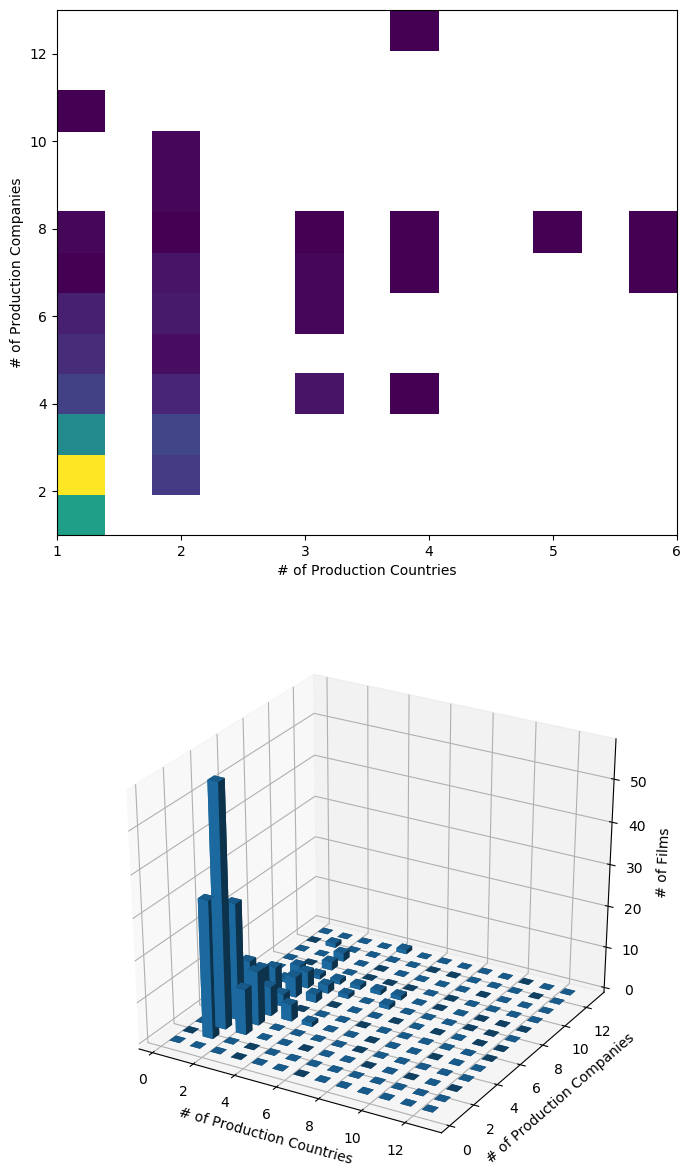

In [50]:
hist, x_ax, y_ax = np.histogram2d(chron_films['Number of Countries'], chron_films['Number of Companies'],
                                      bins=13, range =[[0,13],[0,13]])

#set up the 3d histogram
xpos, ypos = np.meshgrid(x_ax[:-1] + 0.25, y_ax[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()



fig = plt.figure(figsize=(8,15))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2,projection='3d')


ax1.hist2d(chron_films['Number of Countries'], chron_films['Number of Companies'],
           bins=13, cmin=1)
ax1.set_ylabel('# of Production Companies')
ax1.set_xlabel('# of Production Countries')



ax2.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
ax2.set_ylabel('# of Production Companies')
ax2.set_xlabel('# of Production Countries')
ax2.set_zlabel('# of Films')



Unfortunately while there is somewhat of a correlation the data does not show any definite relation between the number of companies that produce a film and the number of countries in which a film is produced. The influence of Hollywood on the film industry is clear here with the majority of the examined films being made by one or two companies in one country (Most likely the United States). There is a small positive correlation however at higher country and company values implying that perhaps if a greater sample size of non-Hollywood films was used in the analysis we would see more of a positive trend. 

# Conclusions

Using data collected from the Movie Database API based off the list of the 250 films on IMDb an investigation was made into the factors relating including box office, budget, film genre, production company and film language. The film budgets and box office were adjusted for inflation over the years which allowed for more accurate comparisons of financial data. English language films dominated the analysis and there was significant skewing of results in some categories due to a specific couple of films (Namely Gone with the Wind) . 

TMDb was found to be a a good source of film data because you can request as much information as required and the process used to search the API for films was relatively straightforward. 

For further analysis of such film data I would consider a number of different approaches: 

I would probably source my original list of films from a more internationally balanced database. The comparison between English speaking films and international films is heavily unbalanced which leads to imprecise analysis for the languages. 

A larger more balanced list of films is definitely required. This could include films that are less financially successful, less critically acclaimed and from a wider range of decades. The top 250 list is good in the sense that is offers a balanced selection of genres and years but in truth this is not a particularly accurate depiction of the current film industry.

I would also consider maybe using a different film API such as IMDb's own API. TMDb is good for finding films but the actual data contained in the JSON files for each film is somewhat lacking. Additional data such as actor data, a more precise financial breakdown or director information could be used to assess what draws audiences to certain films. 

That being said the project highlighted the practicality and ease of use of online APIs for data science purposes.


